# Import and misc

In [1]:
%pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.1 MB/s 
     |████████████████████████████████| 182 kB 80.7 MB/s 
     |████████████████████████████████| 166 kB 77.0 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 166 kB 97.4 MB/s 
     |████████████████████████████████| 162 kB 97.1 MB/s 
     |████████████████████████████████| 162 kB 109.9 MB/s 
     |████████████████████████████████| 158 kB 100.5 MB/s 
     |████████████████████████████████| 157 kB 70.2 MB/s 
     |████████████████████████████████| 157 kB 89.9 MB/s 
     |████████████████████████████████| 157 kB 96.0 MB/s 
     |████████████████████████████████| 157 kB 105.4 MB/s 
     |████████████████████████████████| 157 kB 88.8 MB/s 
     |████████████████████████████████| 157 kB 85.3 MB/s 
     |████████████████████████████████| 157 kB 89.7 MB/s 
     |█████████████████████████

In [2]:
is_train=True

In [3]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
import random
import torch
import numpy as np
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

In [5]:

# Instal latest torch and torchaudio

In [6]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [7]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 32
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [8]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

--2022-11-05 19:46:20--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.196.128, 2607:f8b0:400c:c36::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.196.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   231MB/s    in 6.3s    

2022-11-05 19:46:26 (224 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [9]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [10]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [11]:
dataset.csv.sample(5)

,path,keyword,label
50866,speech_commands/two/f4cae173_nohash_0.wav,two,0
1003,speech_commands/happy/d3a18257_nohash_1.wav,happy,0
38126,speech_commands/right/471a0925_nohash_0.wav,right,0
144,speech_commands/happy/518588b6_nohash_1.wav,happy,0
31651,speech_commands/go/5588c7e6_nohash_0.wav,go,0


### Augmentations

In [12]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [13]:
set_random_seed(41)
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [14]:
# Sample is a dict of utt, word and label
set_random_seed(42)
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [15]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [16]:
set_random_seed(42)
train_sampler = get_sampler(train_set.csv['label'].values)

In [17]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [18]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.
set_random_seed(42)
train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [19]:
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [20]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [21]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [22]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [23]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)

In [24]:
class AttentionMy(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//4),
            nn.Tanh(),
            nn.Linear(hidden_size//4, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNNMy(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.RNN(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = AttentionMy(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output


In [25]:
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [26]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [27]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt


# Training

In [ ]:
config = TaskConfig()
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)


In [ ]:
sum([p.numel() for p in model.parameters()])

25387

In [ ]:
# TRAIN
if is_train:
  wandb.init(project="DLA_HW_KWS", name='full_model')
  for n in range(TaskConfig.num_epochs):
      train_epoch(model, opt, train_loader,
                  melspec_train, config.device)

      au_fa_fr = validation(model, val_loader,
                            melspec_val, config.device)
      wandb.log({"val_metric": au_fa_fr})
      clear_output()
      # plt.plot(history['val_metric'])
      # plt.ylabel('Metric')
      # plt.xlabel('Epoch')
      # plt.grid()
      # plt.show()
      print('END OF EPOCH', n)
  wandb.finish()
  torch.save(model, 'full_model.pth')

END OF EPOCH 19


val_metric,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_metric,3e-05


### Streaming KWS

In [28]:
class StreamConfig(TaskConfig):
    n_fft: int = 400
    win_length: int = 400
    hop_length: int = 160
    max_window_length: int = 12

In [29]:
#type_model 1 or 2 if 1 then CRNN else CRNNMy (model after deep distillation)
class Streaming_CRNN(nn.Module):
  def __init__(self, config: TaskConfig, step_size: int = 1, type_model: int = 1):
    super().__init__()
    self.config = config
    self.type_model = type_model
    self.max_window_length = config.max_window_length
    self.step_size = step_size
    self.device = config.device

    #буфер для аудио
    self.audio_buf_length= config.win_length
    if type_model == 1:
      self.register_buffer(
          'audio_buf',
          torch.zeros(self.audio_buf_length),
          persistent=False
      )
    else:
      self.register_buffer(
          'audio_buf',
          torch.zeros(self.audio_buf_length).half(),
          persistent=False
      )

    if type_model == 1:
      self.model = CRNN(config)
    else:
      self.model = CRNNMy(config)

    assert config.bidirectional == False, "Streaming model cannot to be bidirectional"

    if type_model == 1:
      self.hidden = torch.zeros(config.gru_num_layers, config.hidden_size).to(config.device)
    else:
      self.hidden = torch.zeros(config.gru_num_layers, config.hidden_size).half().to(config.device)
    #буфер для свертки

    self.conv_step_size = step_size * config.stride[1]
    self.conv_buf_length = config.kernel_size[1]
    if type_model == 1:
      self.register_buffer(
          "conv_buf",
          torch.zeros(1, 1, config.n_mels, self.conv_buf_length),
          persistent=False
      )
    else:
      self.register_buffer(
          "conv_buf",
          torch.zeros(1, 1, config.n_mels, self.conv_buf_length).half(),
          persistent=False
      )


    #буффер для rnn
    if type_model == 1:
      self.register_buffer(
          "rnn_buf",
          torch.zeros(self.max_window_length, config.hidden_size),
          persistent=False
      )
    else:
      self.register_buffer(
          "rnn_buf",
          torch.zeros(self.max_window_length, config.hidden_size).half(),
          persistent=False
      )

    #препроцесинг
    self.melspec = torchaudio.transforms.MelSpectrogram(
        sample_rate=config.sample_rate,
        n_fft=config.n_fft,
        win_length=config.win_length,
        hop_length=config.hop_length,
        n_mels=config.n_mels
    )
    #это для определения входа в модель
    self.chunk_length = self.conv_step_size * config.hop_length

  def forward(self, input):
    self.audio_buf = torch.cat((self.audio_buf, input), dim = 0)[-self.audio_buf_length:]
    if self.type_model == 1:
      out_melspec = torch.log(self.melspec(self.audio_buf).clamp_(min=1e-9, max=1e9))
    else:
      out_melspec = torch.log(self.melspec(self.audio_buf).clamp_(min=1e-4, max=1e5)).half()

    self.conv_buf = torch.cat((self.conv_buf, out_melspec[None, None, :, :]), dim = -1)[:,:, :, -self.conv_buf_length:]
    
    out_conv = self.model.conv(self.conv_buf).transpose(-1, -2)[0]
    
    gru_out, self.hidden = self.model.gru(out_conv, self.hidden)

    self.rnn_buf = torch.cat((self.rnn_buf, gru_out), dim = 0)[-self.max_window_length:, :]

    # if self.cnt_rnn >= self.max_window_length:
    #   self.cnt_rnn = self.max_window_length
    #   self.rnn_buf = gru[-self.cnt_rnn:]
    # else:
    #   self.rnn_buf[self.cnt_rnn - self.step_size: self.cnt_rnn] = gru_out

    context_vector = self.model.attention(self.rnn_buf)
    output = self.model.classifier(context_vector)

    prob = output.softmax(dim = -1)[1].item()

    return prob

In [36]:
config_stream = StreamConfig()
stream_full_model = Streaming_CRNN(config_stream)
stream_full_model.model = torch.load('full_model.pth', map_location=config_stream.device)

full_model_script = torch.jit.script(stream_full_model)
full_model_script.save('stream_full_model.pth')

loaded_stream_full_model = torch.jit.load('stream_full_model.pth').to(config_stream.device)

#Тест для striaming model

In [37]:
import IPython

In [38]:
audio_1 = val_df[val_df.label == 0].path[0:20].to_list()
audio_2 = val_df[val_df.label == 1].path[:1].to_list()
audio_3 = val_df[val_df.label == 0].path[20:30].to_list()

In [39]:
paths = audio_1 + audio_2 + audio_3

In [40]:
audio = [torchaudio.load(path)[0].squeeze() for path in paths]

audio_for_stream = torch.cat(audio, dim = 0)
display_.Audio(audio_for_stream, rate=config_stream.sample_rate)

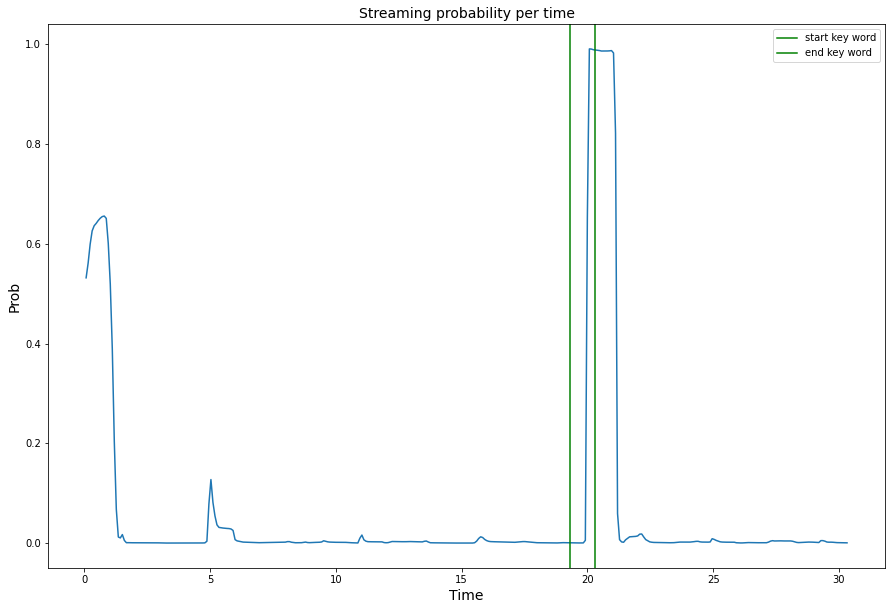

In [41]:
start = 0
for i in range(20):
  start += len(audio[i])

end = start + len(audio[30])

chunk_length = loaded_stream_full_model.chunk_length

input_start = 0

streaming_probs =[]

input_starts = []
while input_start + chunk_length < len(audio_for_stream):
  input = audio_for_stream[input_start:input_start + chunk_length].to(config_stream.device)
  streaming_probs.append(loaded_stream_full_model(input))
  input_start += chunk_length
  input_starts.append(input_start)

input_starts = np.array(input_starts)

plt.rcParams["figure.figsize"] = (15,10)
plt.plot(input_starts / config_stream.sample_rate, streaming_probs)
plt.axvline(x=start/config_stream.sample_rate, color='green', label='start key word')
plt.axvline(x=end/config_stream.sample_rate, color='green', label='end key word',)

plt.xlabel('Time', fontsize=14)
plt.ylabel('Prob', fontsize=14)
plt.title('Streaming probability per time', fontsize=14)
plt.legend()
plt.show()

#Distilation


In [ ]:
def train_epoch_distilation(teacher_model, student_model, opt, loader, log_melspec, device, T=10, alpha =0.005, beta = 0.995):
    student_model.train()
    teacher_model.eval()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        student_logits = student_model(batch)
        # we need probabilities so we use softmax & CE separately
        with torch.no_grad():
          teacher_logits = teacher_model(batch)
        
        student_probs_T = F.softmax(student_logits/T, dim=-1)
        teacher_probs_T = F.softmax(teacher_logits/T, dim=-1)
        dist_loss = -(teacher_probs_T*student_probs_T).sum(dim=1).mean()
        student_loss = F.cross_entropy(student_logits, labels)

        # loss = nn.KLDivLoss()(F.log_softmax(student_logits/T, dim=-1),
        #                      F.softmax(teacher_logits/T, dim=-1)) * (alpha) + \
        #       F.cross_entropy(student_logits, labels) * (1. - alpha)

        loss = alpha*student_loss + beta* dist_loss
        probs =  F.softmax(student_logits, dim=-1)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [44]:
@dataclasses.dataclass
class DistilationConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 4e-4
    weight_decay: float = 1e-5
    num_epochs: int = 30
    n_mels: int = 40
    cnn_out_channels: int = 4
    kernel_size: Tuple[int, int] = (20, 20)
    stride: Tuple[int, int] = (9, 9)
    hidden_size: int = 20
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

In [45]:
distilation_config = DistilationConfig()
distilation_model = CRNN(distilation_config).to(distilation_config.device)

print(distilation_model)

teacher_config = TaskConfig()
teacher_model = CRNN(teacher_config)
teacher_model = torch.load('full_model.pth', teacher_config.device)
teacher_model.config = teacher_config

opt = torch.optim.Adam(
    distilation_model.parameters(),
    lr=distilation_config.learning_rate,
    weight_decay=distilation_config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(20, 20), stride=(9, 9))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(12, 20, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
      (2): Linear(in_features=20, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=20, out_features=2, bias=True)
)


In [ ]:
sum([p.numel() for p in distilation_model.parameters()])

6647

In [ ]:
# TRAIN
set_random_seed(42)
if is_train:
  wandb.init(project="DLA_HW_KWS", name='distilation_model')
  best = 1
  for n in range(distilation_config.num_epochs):

      train_epoch_distilation(teacher_model,distilation_model, opt, train_loader, melspec_train, config.device)
      
      au_fa_fr = validation(distilation_model, val_loader,
                            melspec_val, config.device)
      if au_fa_fr < best:
          best = au_fa_fr
          torch.save(distilation_model, 'best_model.pth')
      wandb.log({"val_metric": au_fa_fr})
      clear_output()
      # plt.plot(history['val_metric'])
      # plt.ylabel('Metric')
      # plt.xlabel('Epoch')
      # plt.grid()
      # plt.show()
      print('END OF EPOCH', n)
  wandb.finish()
  torch.save(distilation_model, 'distilation_model.pth')

END OF EPOCH 29


val_metric,█▇▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_metric,1e-05


#deep distilation 

In [ ]:
def train_epoch_deep_distilation(teacher_model, student_model, opt, loader, log_melspec, device, mod, T=10, alpha =0.005, beta = 0.995):
    student_model.train()
    teacher_model.eval()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)
        batch = batch.unsqueeze(dim=1)


        #   input = input.unsqueeze(dim=1)
        # conv_output = self.conv(input).transpose(-1, -2)
        # gru_output, _ = self.gru(conv_output)
        # contex_vector = self.attention(gru_output)
        # output = self.classifier(contex_vector)
        # return output

        opt.zero_grad()

        # run model # with autocast():
        conv_out_stud =  student_model.conv(batch).transpose(-1, -2)
        gru_out_stud, _= student_model.gru(conv_out_stud)

        contex_vec_stud = student_model.attention(gru_out_stud)
        student_logits = student_model.classifier(contex_vec_stud)
        # we need probabilities so we use softmax & CE separately
        with torch.no_grad():
          conv_out_teach =  teacher_model.conv(batch).transpose(-1, -2)
          gru_out_teach, _ = teacher_model.gru(conv_out_teach)
          contex_vec_teach = teacher_model.attention(gru_out_teach)
          teacher_logits = teacher_model.classifier(contex_vec_teach)
        
        student_probs_T = F.softmax(student_logits/T, dim=-1)
        teacher_probs_T = F.softmax(teacher_logits/T, dim=-1)
        dist_loss = F.kl_div(student_probs_T, teacher_probs_T)
        student_loss = F.cross_entropy(student_logits, labels)

        loss_1=F.mse_loss(mod[1](mod[0](conv_out_stud)), mod[4](mod[0](conv_out_teach)))
        loss_2=F.mse_loss(mod[2](mod[0](gru_out_stud)), mod[5](mod[0](gru_out_teach)))
        loss_3=F.mse_loss(mod[3](mod[0](contex_vec_stud)), mod[6](mod[0](contex_vec_teach)))
        
        
        loss = alpha*student_loss + beta* dist_loss + 0.0005*loss_1 + 0.0005*loss_2 + 0.05*loss_3
        #print(student_loss, dist_loss, loss_1, loss_2, loss_3)
        probs =  F.softmax(student_logits, dim=-1)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()


        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [46]:
@dataclasses.dataclass
class DistilationConfig_new:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 40
    n_mels: int = 40
    cnn_out_channels: int = 4
    kernel_size: Tuple[int, int] = (20, 20)
    stride: Tuple[int, int] = (9, 9)
    hidden_size: int = 16
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

In [47]:
from torch.optim.lr_scheduler import StepLR
distilation_config_new = DistilationConfig_new()
distilation_model_new = CRNN(distilation_config_new).to(distilation_config_new.device)

print(distilation_model_new)

teacher_config = TaskConfig()
teacher_model = CRNN(teacher_config)
teacher_model = torch.load('full_model.pth', teacher_config.device)
teacher_model.config = teacher_config



mod = nn.Sequential(
      nn.Flatten(),
      nn.Linear(120, 10),
      nn.Linear(160, 10),
      nn.Linear(16, 10),
      nn.Linear(1584, 10),
      nn.Linear(352, 10),
      nn.Linear(32, 10),
)
mod = mod.to(distilation_config_new.device)

opt = torch.optim.Adam(
    list(distilation_model_new.parameters()) + list(mod.parameters()),
    lr=distilation_config_new.learning_rate,
    weight_decay=distilation_config_new.weight_decay
)


CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(20, 20), stride=(9, 9))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(12, 16, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
      (2): Linear(in_features=16, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=16, out_features=2, bias=True)
)


In [ ]:
sum([p.numel() for p in distilation_model_new.parameters()])

4999

In [ ]:
# TRAIN
set_random_seed(42)
if is_train:
  wandb.init(project="DLA_HW_KWS", name='distilation_model_new')
  best = 1
  for n in range(distilation_config_new.num_epochs):

      train_epoch_deep_distilation(teacher_model,distilation_model_new, opt, train_loader, melspec_train, config.device, mod, T=10, alpha = 0.005, beta = 0.995)

      au_fa_fr = validation(distilation_model_new, val_loader,
                            melspec_val, config.device)
      if au_fa_fr < best:
          best = au_fa_fr
          torch.save(distilation_model_new, 'best_model_new.pth')
      wandb.log({"val_metric": au_fa_fr})
      clear_output()
      # plt.plot(history['val_metric'])
      # plt.ylabel('Metric')
      # plt.xlabel('Epoch')
      # plt.grid()
      # plt.show()
      print('END OF EPOCH', n)
  wandb.finish()
  torch.save(distilation_model_new, 'distilation_model_new.pth')

END OF EPOCH 39


val_metric,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_metric,2e-05


#deep distilation with another model

In [ ]:
def train_epoch_deep_distilation_new(teacher_model, student_model, opt, loader, log_melspec, device, mod, T=10, alpha =0.005, beta = 0.995):
    student_model.train()
    teacher_model.eval()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)
        batch = batch.unsqueeze(dim=1)


        #   input = input.unsqueeze(dim=1)
        # conv_output = self.conv(input).transpose(-1, -2)
        # gru_output, _ = self.gru(conv_output)
        # contex_vector = self.attention(gru_output)
        # output = self.classifier(contex_vector)
        # return output

        opt.zero_grad()

        # run model # with autocast():
        conv_out_stud =  student_model.conv(batch).transpose(-1, -2)
        gru_out_stud, _= student_model.gru(conv_out_stud)

        contex_vec_stud = student_model.attention(gru_out_stud)
        student_logits = student_model.classifier(contex_vec_stud)
        # we need probabilities so we use softmax & CE separately
        with torch.no_grad():
          conv_out_teach =  teacher_model.conv(batch).transpose(-1, -2)
          gru_out_teach, _ = teacher_model.gru(conv_out_teach)
          contex_vec_teach = teacher_model.attention(gru_out_teach)
          teacher_logits = teacher_model.classifier(contex_vec_teach)
        
        student_probs_T = F.softmax(student_logits/T, dim=-1)
        teacher_probs_T = F.softmax(teacher_logits/T, dim=-1)
        dist_loss = -(teacher_probs_T*student_probs_T).sum(dim=1).mean()
        student_loss = F.cross_entropy(student_logits, labels)

        loss_1=F.mse_loss(mod[1](mod[0](conv_out_stud)), mod[4](mod[0](conv_out_teach)))
        loss_2=F.mse_loss(mod[2](mod[0](gru_out_stud)), mod[5](mod[0](gru_out_teach)))
        loss_3=F.mse_loss(mod[3](mod[0](contex_vec_stud)), mod[6](mod[0](contex_vec_teach)))
        
        
        loss = alpha*student_loss + beta* dist_loss + 0.0005*loss_1 + 0.0005*loss_2 + 0.05*loss_3
        #print(student_loss, dist_loss, loss_1, loss_2, loss_3)
        probs =  F.softmax(student_logits, dim=-1)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [48]:
@dataclasses.dataclass
class DistilationConfig_new_model:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 4e-4
    weight_decay: float = 1e-5
    num_epochs: int = 30
    n_mels: int = 40
    cnn_out_channels: int = 4
    kernel_size: Tuple[int, int] = (20, 20)
    stride: Tuple[int, int] = (9, 9)
    hidden_size: int = 16
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

In [49]:
from torch.optim.lr_scheduler import StepLR
distilation_config_new_model = DistilationConfig_new_model()
distilation_model_new_model = CRNNMy(distilation_config_new_model).to(distilation_config_new_model.device)

print(distilation_model_new_model)

teacher_config = TaskConfig()
teacher_model = CRNN(teacher_config)
teacher_model = torch.load('full_model.pth', teacher_config.device)
teacher_model.config = teacher_config



mod = nn.Sequential(
      nn.Flatten(),
      nn.Linear(120, 10),
      nn.Linear(160, 10),
      nn.Linear(16, 10),
      nn.Linear(1584, 10),
      nn.Linear(352, 10),
      nn.Linear(32, 10),
)
mod = mod.to(distilation_config_new_model.device)

opt = torch.optim.Adam(
    list(distilation_model_new_model.parameters()) + list(mod.parameters()),
    lr=distilation_config_new_model.learning_rate,
    weight_decay=distilation_config_new_model.weight_decay
)


CRNNMy(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(20, 20), stride=(9, 9))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): RNN(12, 16, num_layers=2, batch_first=True, dropout=0.1)
  (attention): AttentionMy(
    (energy): Sequential(
      (0): Linear(in_features=16, out_features=4, bias=True)
      (1): Tanh()
      (2): Linear(in_features=4, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=16, out_features=2, bias=True)
)


In [ ]:

sum([p.numel() for p in distilation_model_new_model.parameters()])

2735

In [ ]:
# TRAIN
set_random_seed(42)
if is_train:
  wandb.init(project="DLA_HW_KWS", name='distilation_model_new_model')
  best = 1
  for n in range(distilation_config_new_model.num_epochs):

      train_epoch_deep_distilation_new(teacher_model,distilation_model_new_model, opt, train_loader, melspec_train, config.device, mod, T=10, alpha = 0.005, beta = 0.995)

      au_fa_fr = validation(distilation_model_new_model, val_loader,
                            melspec_val, config.device)
      if au_fa_fr < best:
          best = au_fa_fr
          torch.save(distilation_model_new_model, 'best_model_new_model.pth')
      wandb.log({"val_metric": au_fa_fr})
      clear_output()

      print('END OF EPOCH', n)
  wandb.finish()
  torch.save(distilation_model_new_model, 'distilation_model_new_model.pth')

END OF EPOCH 29


val_metric,█▆▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_metric,2e-05


#pruning

#distilation and fp16

In [ ]:
dist_model = CRNN(distilation_config)
dist_model = torch.load('best_model.pth', distilation_config.device)
dist_model.config = distilation_config

In [ ]:
class LogMelspec_fp16:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-4, max=1e5)).half()

In [ ]:
melspec_train_fp16 = LogMelspec_fp16(is_train=True, config=DistilationConfig)
melspec_val_fp16 = LogMelspec_fp16(is_train=False, config=DistilationConfig)

In [ ]:
au_fa_fr = validation(dist_model, val_loader,
                            melspec_val, distilation_config.device)

au_fa_fr_fp16 = validation(dist_model.half(), val_loader,
                            melspec_val_fp16, distilation_config.device)

print(au_fa_fr, au_fa_fr_fp16)

102it [00:03, 26.41it/s]
102it [00:03, 27.25it/s]


9.524205939470271e-06 8.103929615163299e-06


In [ ]:
sum([p.numel() for p in dist_model.parameters()])

6647

In [ ]:
dist_model = CRNN(distilation_config)
dist_model = torch.load('best_model.pth', distilation_config.device)
dist_model.config = distilation_config
dist_model_fp16 = dist_model.half()
torch.save(dist_model_fp16, 'distilation_model_fp16.pth')

In [ ]:
dist_model_new = CRNN(distilation_config_new)
dist_model_new = torch.load('best_model_new.pth', distilation_config_new.device)
dist_model_new.config = distilation_config_new

In [ ]:
au_fa_fr = validation(dist_model_new, val_loader,
                            melspec_val, distilation_config_new.device)

au_fa_fr_fp16 = validation(dist_model_new.half(), val_loader,
                            melspec_val_fp16, distilation_config_new.device)

print(au_fa_fr, au_fa_fr_fp16)

102it [00:03, 26.11it/s]
102it [00:03, 26.25it/s]


2.4544523201153647e-05 1.5846822601668738e-05


In [ ]:
dist_model_new = CRNN(distilation_config_new)
dist_model_new = torch.load('best_model_new.pth', distilation_config_new.device)
dist_model_new.config = distilation_config_new
dist_model_new_fp16 = dist_model_new.half()
torch.save(dist_model_new_fp16, 'distilation_model_new_fp16.pth')

In [ ]:
dist_model_new_model = CRNN(distilation_config_new_model)
dist_model_new_model = torch.load('best_model_new_model.pth', distilation_config_new_model.device)
dist_model_new_model.config = distilation_config_new_model

In [ ]:
au_fa_fr = validation(dist_model_new_model, val_loader,
                            melspec_val, distilation_config_new.device)

au_fa_fr_fp16 = validation(dist_model_new_model.half(), val_loader,
                            melspec_val_fp16, distilation_config_new.device)

print(au_fa_fr, au_fa_fr_fp16)

102it [00:03, 26.25it/s]
102it [00:03, 26.86it/s]


1.977048513625627e-05 1.6980656642081865e-05


In [50]:
dist_model_new_model = CRNN(distilation_config_new_model)
dist_model_new_model = torch.load('best_model_new_model.pth', distilation_config_new_model.device)
dist_model_new_model.config = distilation_config_new_model
dist_model_new_fp16_model = dist_model_new_model.half()
torch.save(dist_model_new_fp16_model, 'distilation_model_new_fp16_model.pth')

#Quantization

In [ ]:
@dataclasses.dataclass
class DistilationConfigQuant:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 4e-4
    weight_decay: float = 1e-5
    num_epochs: int = 30
    n_mels: int = 40
    cnn_out_channels: int = 4
    kernel_size: Tuple[int, int] = (20, 20)
    stride: Tuple[int, int] = (9, 9)
    hidden_size: int = 20
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = 'cpu'

In [ ]:
quant_dist_config =  DistilationConfigQuant()
dist_model = CRNN(quant_dist_config)
dist_model = torch.load('best_model.pth', quant_dist_config.device)
dist_model.config = quant_dist_config
dist_model_int8 = torch.quantization.quantize_dynamic(
    dist_model,  # the original model
    {torch.nn.GRU, torch.nn.Linear},  # a set of layers to dynamically quantize
    dtype=torch.qint8)  
melspec_val_quant = LogMelspec(is_train=False, config=quant_dist_config)


In [ ]:
au_fa_fr = validation(dist_model_int8, val_loader, melspec_val_quant, quant_dist_config.device)
print(au_fa_fr)

102it [00:04, 20.80it/s]


8.441096053496675e-06


In [ ]:
torch.save(dist_model_int8, 'distilation_model_int8.pth')

In [ ]:
@dataclasses.dataclass
class DistilationConfig_newQuant:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 4e-4
    weight_decay: float = 1e-5
    num_epochs: int = 30
    n_mels: int = 40
    cnn_out_channels: int = 4
    kernel_size: Tuple[int, int] = (20, 20)
    stride: Tuple[int, int] = (9, 9)
    hidden_size: int = 16
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device =  'cpu'

In [ ]:
quant_dist_config_new =  DistilationConfig_newQuant()
dist_model_new = CRNN(quant_dist_config_new)
dist_model_new = torch.load('best_model_new.pth', quant_dist_config_new.device)
dist_model_new.config = quant_dist_config_new
dist_model_new_int8 = torch.quantization.quantize_dynamic(
    dist_model_new,  # the original model
    {torch.nn.GRU, torch.nn.Linear},  # a set of layers to dynamically quantize
    dtype=torch.qint8)  
melspec_val_quant_new = LogMelspec(is_train=False, config=quant_dist_config_new)


In [ ]:
au_fa_fr = validation(dist_model_new_int8, val_loader, melspec_val_quant_new, quant_dist_config_new.device)
print(au_fa_fr)

102it [00:04, 21.05it/s]


2.5573925158897148e-05


In [ ]:
torch.save(dist_model_new_int8, 'distilation_model_new_int8.pth')

In [ ]:
@dataclasses.dataclass
class DistilationConfig_new_modelQuant:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 4e-4
    weight_decay: float = 1e-5
    num_epochs: int = 30
    n_mels: int = 40
    cnn_out_channels: int = 4
    kernel_size: Tuple[int, int] = (20, 20)
    stride: Tuple[int, int] = (9, 9)
    hidden_size: int = 16
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = 'cpu'

In [ ]:
quant_dist_config_new_model =  DistilationConfig_new_modelQuant()
dist_model_new_model = CRNN(quant_dist_config_new_model)
dist_model_new_model = torch.load('best_model_new_model.pth', quant_dist_config_new_model.device)
dist_model_new_model.config = quant_dist_config_new_model
dist_model_new_int8_model = torch.quantization.quantize_dynamic(
    dist_model_new_model,  # the original model
    {torch.nn.RNN, torch.nn.Linear},  # a set of layers to dynamically quantize
    dtype=torch.qint8)  
melspec_val_quant_new = LogMelspec(is_train=False, config=quant_dist_config_new_model)


In [ ]:
au_fa_fr = validation(dist_model_new_int8_model, val_loader, melspec_val_quant_new, quant_dist_config_new_model.device)
print(au_fa_fr)

102it [00:04, 20.68it/s]


1.9758550041094028e-05


In [ ]:
torch.save(dist_model_new_int8_model, 'distilation_model_new_int8_model.pth')

#Сравнение

In [ ]:
dist_model = CRNN(distilation_config)
dist_model = torch.load('best_model.pth', distilation_config.device)
dist_model.config = distilation_config

dist_model_new = CRNN(distilation_config_new)
dist_model_new = torch.load('best_model_new.pth', distilation_config_new.device)
dist_model_new.config = distilation_config_new

dist_model_new_model = CRNN(distilation_config_new_model)
dist_model_new_model = torch.load('best_model_new_model.pth', distilation_config_new_model.device)
dist_model_new_model.config = distilation_config_new_model

teacher_config = TaskConfig()
teacher_model = CRNN(teacher_config)
teacher_model = torch.load('full_model.pth', teacher_config.device)
teacher_model.config = teacher_config

In [ ]:
models = [teacher_model, dist_model, dist_model_new, dist_model_new_model, 
          dist_model_fp16, dist_model_int8, 
          dist_model_new_fp16, dist_model_new_int8,
          dist_model_new_fp16_model, dist_model_new_int8_model]
configs= [teacher_config, distilation_config, distilation_config_new,  distilation_config_new_model,
          distilation_config, quant_dist_config, 
          distilation_config_new, quant_dist_config_new,
          distilation_config_new_model, quant_dist_config_new_model]
names = ["full", "dist", "deep_dist", "deep_dist_small",
         "dist+fp16", "dist+quant", 
         "deep_dist+fp16", "deep_dist+quant",
         "deep_dist_small+fp16", "deep_dist_small+quant"
         ]

In [ ]:
import tempfile
def get_size_in_megabytes(model):
    # https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html#look-at-model-size
    with tempfile.TemporaryFile() as f:
        torch.save(model.state_dict(), f)
        size = f.tell() / 2**20
    return size

102it [00:04, 23.20it/s]
102it [00:03, 27.50it/s]
102it [00:03, 27.22it/s]
102it [00:03, 26.95it/s]
102it [00:03, 27.46it/s]
102it [00:04, 20.99it/s]
102it [00:04, 23.21it/s]
102it [00:04, 21.06it/s]
102it [00:03, 26.57it/s]
102it [00:04, 20.71it/s]


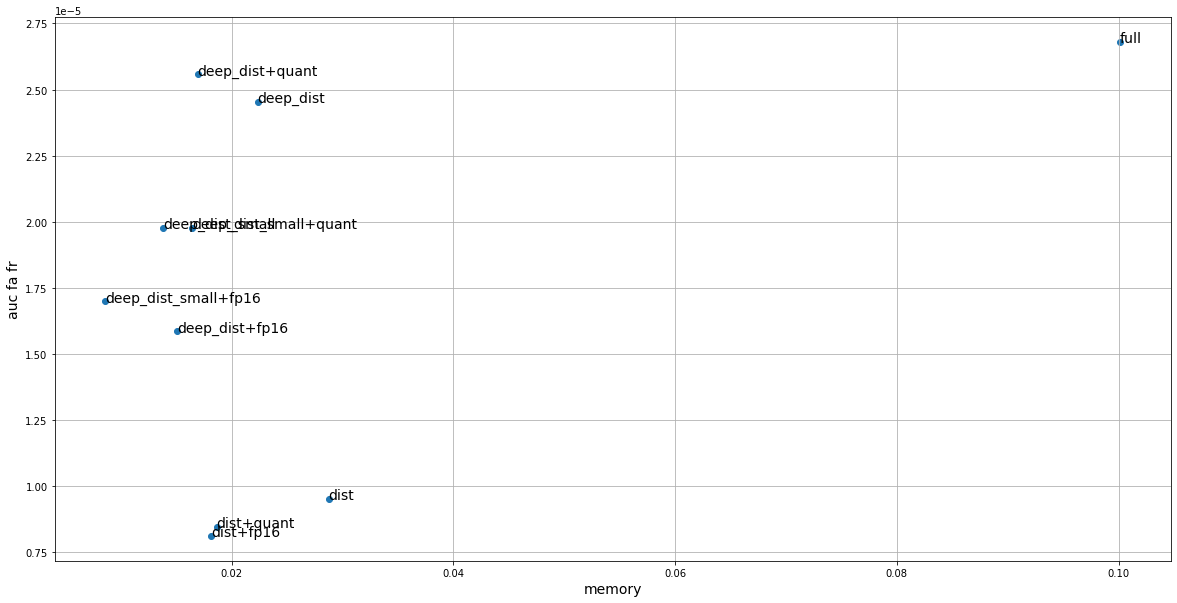

In [ ]:
res = []
plt.rcParams["figure.figsize"] = (20,10)
for i in range(len(models)):
  if i == 4 or i == 6 or i == 8:
    melspec_val = LogMelspec_fp16(is_train=False, config=configs[i])
  else:
    melspec_val = LogMelspec(is_train=False, config=configs[i])
  au_fa_fr = validation(models[i], val_loader, melspec_val, configs[i].device)
  mem =  get_size_in_megabytes(models[i])
  res.append([mem, au_fa_fr])
for i in range(len(models)):
  plt.annotate(names[i], (res[i][0], res[i][1]),  fontsize=14)
res = np.array(res)
plt.scatter(res[:, 0], res[:, 1])
plt.xlabel('memory', fontsize=14)
plt.ylabel('auc fa fr', fontsize=14)
plt.grid()
plt.show()

In [ ]:
compression_rate = res[0][0]/res[-2][0]
print("compression_rate", compression_rate)

compression_rate 11.618262313226342


In [ ]:
dist_model = CRNN(distilation_config)
dist_model = torch.load('best_model.pth', distilation_config.device)
dist_model.config = distilation_config

dist_model_new = CRNN(distilation_config_new)
dist_model_new = torch.load('best_model_new.pth', distilation_config_new.device)
dist_model_new.config = distilation_config_new

dist_model_new_model = CRNN(distilation_config_new_model)
dist_model_new_model = torch.load('best_model_new_model.pth', distilation_config_new_model.device)
dist_model_new_model.config = distilation_config_new_model

teacher_config = TaskConfig()
teacher_model = CRNN(teacher_config)
teacher_model = torch.load('full_model.pth', teacher_config.device)
teacher_model.config = teacher_config

In [ ]:
#квантизация не меняет флопы
models = [teacher_model, dist_model, dist_model_new, dist_model_new_model, 
          dist_model_fp16, dist_model, 
          dist_model_new_fp16, dist_model_new,
          dist_model_new_fp16_model, dist_model_new_model]
configs= [teacher_config, distilation_config, distilation_config_new,  distilation_config_new_model,
          distilation_config, distilation_config, 
          distilation_config_new, distilation_config_new,
          distilation_config_new_model, distilation_config_new_model]
names = ["full", "dist", "deep_dist", "deep_dist_small",
         "dist+fp16", "dist+quant", 
         "deep_dist+fp16", "deep_dist+quant",
         "deep_dist_small+fp16", "deep_dist_small+quant"
         ]

In [ ]:
%pip install thop

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from thop import profile 

torch.Size([1, 1, 40, 201])


102it [00:03, 26.06it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
torch.Size([1, 1, 40, 201])


102it [00:05, 18.83it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
torch.Size([1, 1, 40, 201])


102it [00:04, 23.57it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
torch.Size([1, 1, 40, 201])


102it [00:04, 24.51it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_rnn() for <class 'torch.nn.modules.rnn.RNN'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
torch.Size([1, 1, 40, 201])


102it [00:05, 20.07it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
torch.Size([1, 1, 40, 201])


102it [00:03, 27.43it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
torch.Size([1, 1, 40, 201])


102it [00:03, 26.43it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
torch.Size([1, 1, 40, 201])


102it [00:03, 27.28it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
torch.Size([1, 1, 40, 201])


102it [00:03, 26.23it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_rnn() for <class 'torch.nn.modules.rnn.RNN'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
torch.Size([1, 1, 40, 201])


102it [00:03, 27.10it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_rnn() for <class 'torch.nn.modules.rnn.RNN'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


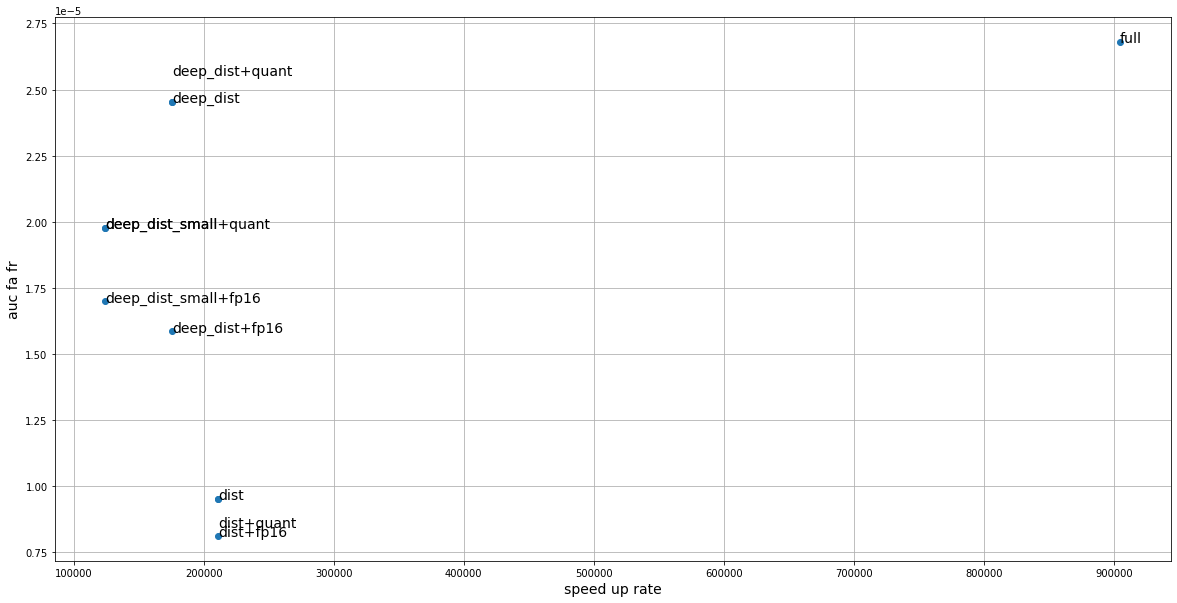

In [ ]:
res_speed = []
plt.rcParams["figure.figsize"] = (20,10)
for i in range(len(models)):
  if i == 4 or i == 6 or i == 8:
    melspec_val = LogMelspec_fp16(is_train=False, config=configs[i])
  else:
    melspec_val = LogMelspec(is_train=False, config=configs[i])
  data =  torch.rand(configs[i].sample_rate * 2).to(configs[i].device)
  data = melspec_val(data)
  data = data.unsqueeze(0)
  data = data.unsqueeze(0)
  print(data.shape)
  au_fa_fr = validation(models[i], val_loader, melspec_val, configs[i].device)

  macs, params = profile(models[i], data)

  res_speed.append([macs, au_fa_fr])
for i in range(len(models)):
  plt.annotate(names[i], (res_speed[i][0], res[i][1]), fontsize=14)
res_speed = np.array(res_speed)
plt.scatter(res_speed[:, 0], res_speed[:, 1])
plt.xlabel('speed up rate', fontsize=14)
plt.ylabel('auc fa fr', fontsize=14)
plt.grid()
plt.show()

In [ ]:
print(res_speed[0][0])

904608.0


In [ ]:
speed_up_rate = res_speed[0][0]/res_speed[-2][0]
print("speed_up_rate", speed_up_rate)

speed_up_rate 7.269664727249349


#Сохранение лучшей модели в нужном формате

In [51]:
dist_model_new_model = CRNN(distilation_config_new_model)
dist_model_new_model = torch.load('best_model_new_model.pth', distilation_config_new_model.device)
dist_model_new_model.config = distilation_config_new_model
dist_model_new_fp16_model = dist_model_new_model.half()

model_scripted = torch.jit.script(dist_model_new_fp16_model)
model_scripted.save('my_model.pth')

streaming_small_model = torch.jit.load('my_model.pth')

In [ ]:
melspec_val_fp16 = LogMelspec_fp16(is_train=False, config=DistilationConfig)
au_fa_fr = validation(streaming_small_model, val_loader,
                            melspec_val_fp16, distilation_config_new.device)
print(au_fa_fr)

102it [00:05, 17.25it/s]


1.7013478153778034e-05


***эта часть делалась позже, поэтому может быть слетел сид... а как изветно val уже не тот:)***

In [52]:
class StreamConfigSmall(DistilationConfig_new_model):
    n_fft: int = 400
    win_length: int = 400
    hop_length: int = 160
    max_window_length: int = 12

In [53]:
config_stream_small = StreamConfigSmall
stream_small_model = Streaming_CRNN(config_stream_small, type_model = 2)
stream_small_model.model = torch.load('distilation_model_new_fp16_model.pth', map_location=config_stream_small.device)

small_model_script = torch.jit.script(stream_small_model)
small_model_script.save('stream_small_model.pth')

loaded_stream_small_model = torch.jit.load('stream_small_model.pth').to(config_stream_small.device)

In [66]:
audio_1 = val_df[val_df.label == 0].path[20:40].to_list()
audio_2 = val_df[val_df.label == 1].path[:1].to_list()
audio_3 = val_df[val_df.label == 0].path[50:60].to_list()

In [67]:
paths = audio_1 + audio_2 + audio_3

In [68]:
audio = [torchaudio.load(path)[0].squeeze() for path in paths]

audio_for_stream = torch.cat(audio, dim = 0)
display_.Audio(audio_for_stream, rate=config_stream.sample_rate)

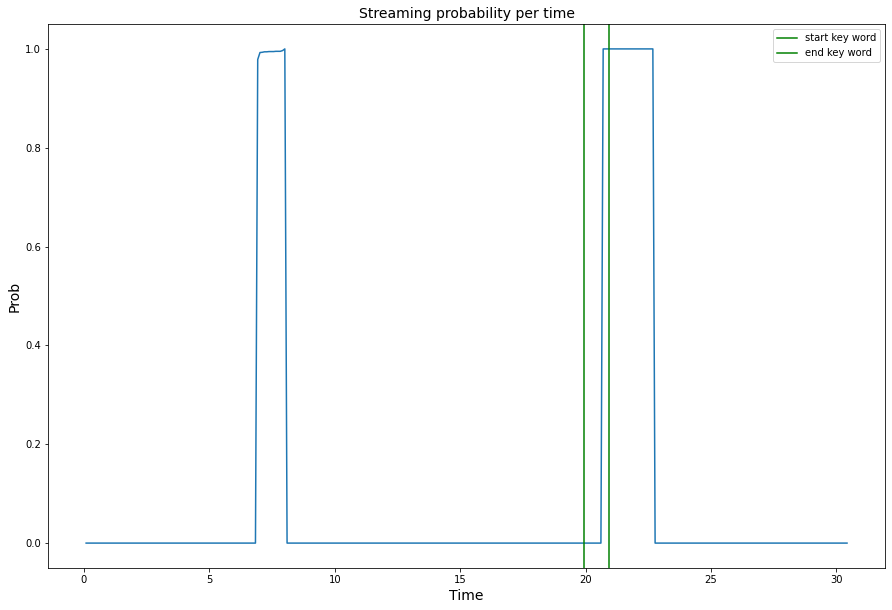

In [69]:
start = 0
for i in range(20):
  start += len(audio[i])

end = start + len(audio[20])

chunk_length = loaded_stream_small_model.chunk_length

input_start = 0

streaming_probs =[]

input_starts = []
while input_start + chunk_length < len(audio_for_stream):
  input = audio_for_stream[input_start:input_start + chunk_length].to(config_stream_small.device)
  streaming_probs.append(loaded_stream_small_model(input))
  input_start += chunk_length
  input_starts.append(input_start)

input_starts = np.array(input_starts)

plt.rcParams["figure.figsize"] = (15,10)
plt.plot(input_starts / config_stream.sample_rate, streaming_probs)
plt.axvline(x=start/config_stream.sample_rate, color='green', label='start key word')
plt.axvline(x=end/config_stream.sample_rate, color='green', label='end key word',)

plt.xlabel('Time', fontsize=14)
plt.ylabel('Prob', fontsize=14)
plt.title('Streaming probability per time', fontsize=14)
plt.legend()
plt.show()

In [3]:
mark = 3.5 * 7.269664727249349/10 + 3.5 * 10/10 + 3
print('final_mark', mark)

final_mark 9.044382654537273
